#Pavement Condition Analysis using Big Data & ML

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import col, avg, mean, when, monotonically_increasing_id
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, mean, stddev, min, max
import plotly.express as px
import plotly.graph_objects as go



In [0]:
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/rarvapal@gmu.edu/Combined_Pavement_Dataset_from_Excel-1.csv")

In [0]:
column_names = pd.DataFrame(df1.columns, columns=["Column Names"])
column_names


,Column Names
0,STATE_CODE
1,STATE_CODE_EXP
2,SHRP_ID
3,LATITUDE
4,LONGITUDE
...,...
131,ESTAR
132,PREDICTIVE_MODEL
133,PREDICTIVE_MODEL_EXP
134,LAB_MEASURED


**EDA**

Scatterplot – FREQUENCY vs ESTAR colored by TEMPERATURE

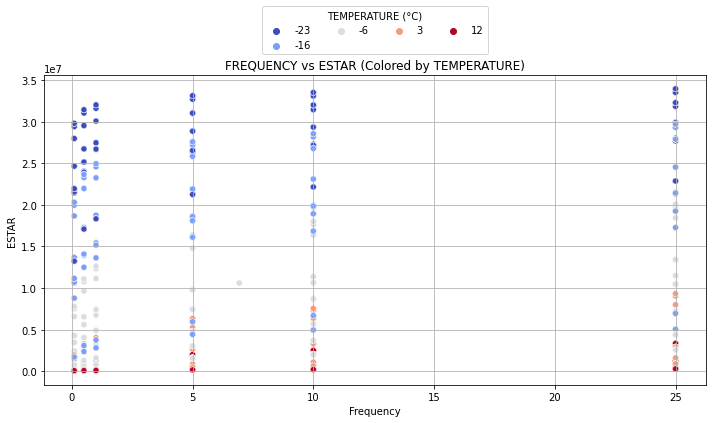

In [0]:
# Round temperature values (e.g., to nearest int for clean categories)
pandas_df['TEMP_ROUNDED'] = pandas_df['TEMPERATURE'].round(0).astype(int)

# Plot: FREQUENCY vs ESTAR with rounded temperature labels and legend on top
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pandas_df,
    x='FREQUENCY',
    y='ESTAR',
    hue='TEMP_ROUNDED',
    palette='coolwarm'
)
plt.title("FREQUENCY vs ESTAR (Colored by TEMPERATURE)")
plt.xlabel("Frequency")
plt.ylabel("ESTAR")
plt.grid(True)
plt.legend(title='TEMPERATURE (°C)', bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=4)
plt.tight_layout()
plt.show()


Distribution of ESTAR by Top 10 States

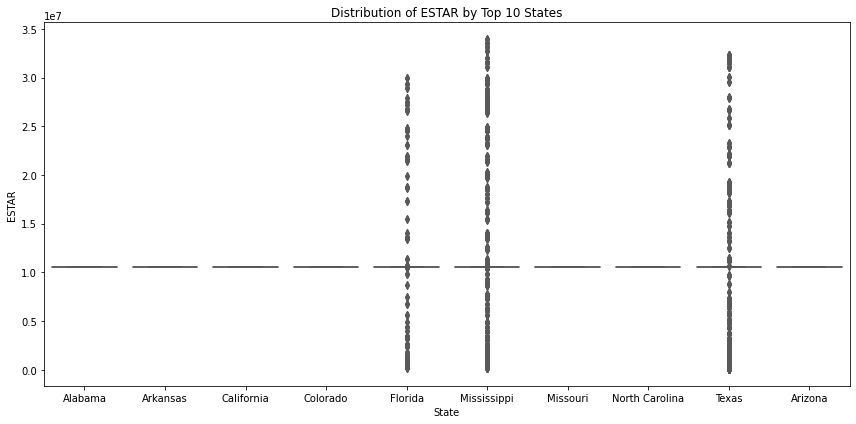

In [0]:
top_states = pandas_df['STATE_CODE_EXP'].value_counts().nlargest(10).index
filtered_df = pandas_df[pandas_df['STATE_CODE_EXP'].isin(top_states)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df, x='STATE_CODE_EXP', y='ESTAR', palette='Set2')
plt.title("Distribution of ESTAR by Top 10 States")
plt.xlabel("State")
plt.ylabel("ESTAR")
plt.tight_layout()
plt.show()


Heatmap of Average ESTAR by State and Construction Number

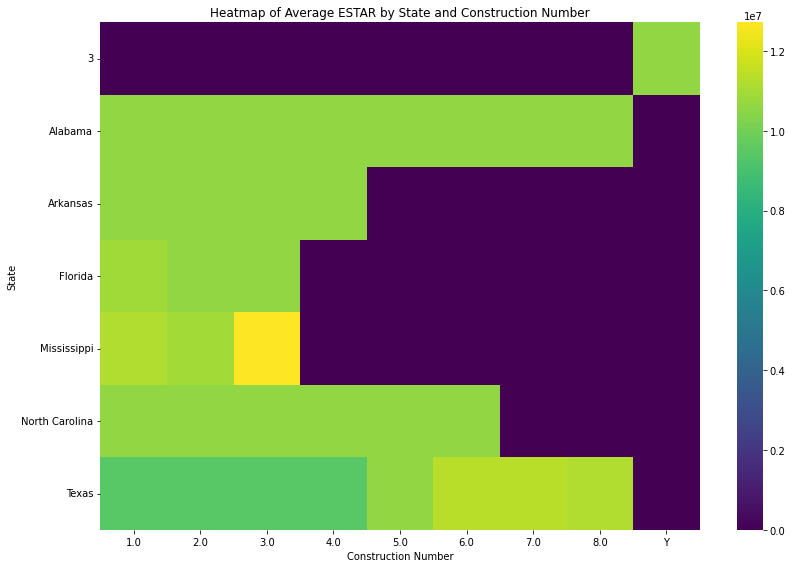

In [0]:
heatmap_data = pandas_df.groupby(['STATE_CODE_EXP', 'CONSTRUCTION_NO'])['ESTAR'].mean().unstack().fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis')
plt.title("Heatmap of Average ESTAR by State and Construction Number")
plt.xlabel("Construction Number")
plt.ylabel("State")
plt.tight_layout()
plt.show()


Bar Plot of Counts per CONSTRUCTION_NO

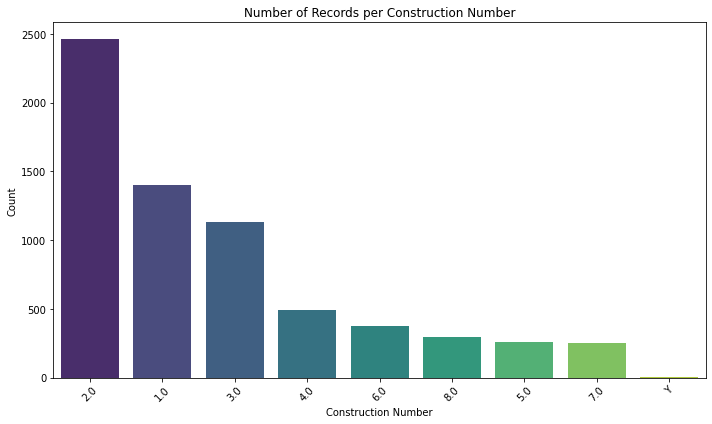

In [0]:
plt.figure(figsize=(10, 6))
sns.countplot(data=pandas_df, x='CONSTRUCTION_NO', order=pandas_df['CONSTRUCTION_NO'].value_counts().index, palette='viridis')
plt.title("Number of Records per Construction Number")
plt.xlabel("Construction Number")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Visualizing Material Stiffness (ESTAR) Across States

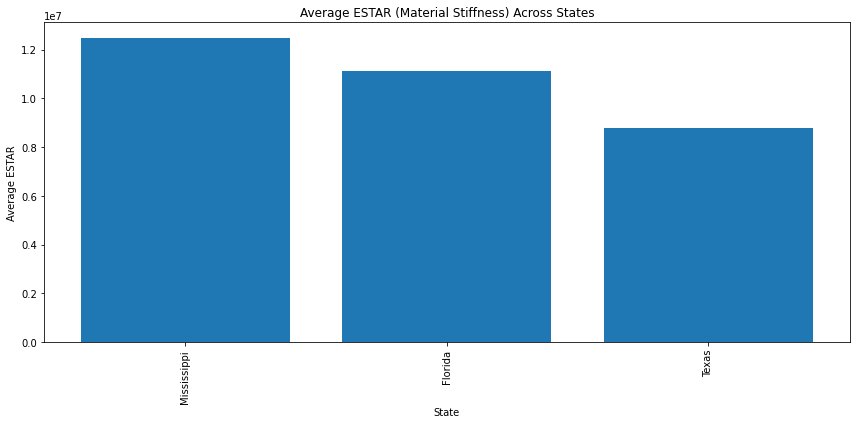

In [0]:
df1 = df1.withColumn("ESTAR", col("ESTAR").cast("float"))

avg_estar_df = df1.groupBy("STATE_CODE_EXP").agg(avg("ESTAR").alias("Average_ESTAR"))

avg_estar_pd = avg_estar_df.toPandas().sort_values(by="Average_ESTAR", ascending=False)

plt.figure(figsize=(12,6))
plt.bar(avg_estar_pd["STATE_CODE_EXP"], avg_estar_pd["Average_ESTAR"])
plt.xticks(rotation=90)
plt.title("Average ESTAR (Material Stiffness) Across States")
plt.xlabel("State")
plt.ylabel("Average ESTAR")
plt.tight_layout()
plt.show()


Clustering Pavement Segments (using KMeans)

In [0]:
df1 = df1.withColumn("FREQUENCY", col("FREQUENCY").cast("float"))
df1 = df1.withColumn("TEMPERATURE", col("TEMPERATURE").cast("float"))

df_cluster = df1.select("ESTAR", "FREQUENCY", "TEMPERATURE").dropna()

assembler = VectorAssembler(inputCols=["ESTAR", "FREQUENCY", "TEMPERATURE"], outputCol="features")
df_vector = assembler.transform(df_cluster)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

kmeans = KMeans(k=3, featuresCol="scaledFeatures", predictionCol="cluster")
model = kmeans.fit(df_scaled)
result = model.transform(df_scaled)

result.groupBy("cluster").count().show()


+-------+-----+
|cluster|count|
+-------+-----+
|      1|  172|
|      2|  425|
|      0|  633|
+-------+-----+



In [0]:
cols = ["FREQUENCY", "TEMPERATURE", "AIR_VOIDS_AVG_WP", "ASPHALT_CONTENT_MEAN", "ESTAR"]
for c in cols:
    non_null_count = df1.filter(col(c).isNotNull()).count()
    print(f"{c} non-null rows: {non_null_count}")


FREQUENCY non-null rows: 1230
TEMPERATURE non-null rows: 1230
AIR_VOIDS_AVG_WP non-null rows: 117
ASPHALT_CONTENT_MEAN non-null rows: 117
ESTAR non-null rows: 1230


In [0]:
df_model = df1.select(*cols)

for colname in cols:
    df_model = df_model.withColumn(colname, col(colname).cast("float"))

df_model = df_model.dropna(subset=cols)

print("Final dataset count:", df_model.count())


Final dataset count: 0


In [0]:

cols = ["FREQUENCY", "TEMPERATURE", "ESTAR"]

df_model = df1.select(*cols)
for colname in cols:
    df_model = df_model.withColumn(colname, col(colname).cast("float"))

df_model = df_model.dropna()

assembler = VectorAssembler(inputCols=cols[:-1], outputCol="features")  
df_vector = assembler.transform(df_model).select("features", "ESTAR")

train_df, test_df = df_vector.randomSplit([0.8, 0.2], seed=42)
print("Train Count:", train_df.count(), "| Test Count:", test_df.count())

rf = RandomForestRegressor(labelCol="ESTAR", featuresCol="features", numTrees=100)
model = rf.fit(train_df)

predictions = model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="ESTAR", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"RMSE on test data: {rmse:.2f}")


Train Count: 1020 | Test Count: 210
RMSE on test data: 4432727.43


Using GBTRegressor for Predicting ESTAR

In [0]:
cols = ["FREQUENCY", "TEMPERATURE", "ESTAR"]
df_model = df1.select(*cols)

for colname in cols:
    df_model = df_model.withColumn(colname, col(colname).cast("float"))
df_model = df_model.dropna()

assembler = VectorAssembler(inputCols=cols[:-1], outputCol="features")  
df_vector = assembler.transform(df_model).select("features", "ESTAR")

train_df, test_df = df_vector.randomSplit([0.8, 0.2], seed=42)
print("GBT - Train Count:", train_df.count(), "| Test Count:", test_df.count())

gbt = GBTRegressor(labelCol="ESTAR", featuresCol="features", maxIter=50)
gbt_model = gbt.fit(train_df)

predictions = gbt_model.transform(test_df)
evaluator = RegressionEvaluator(labelCol="ESTAR", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"GBT RMSE on test data: {rmse:.2f}")


GBT - Train Count: 1020 | Test Count: 210
GBT RMSE on test data: 4244335.08


Plot Actual vs Predicted ESTAR (for GBT)

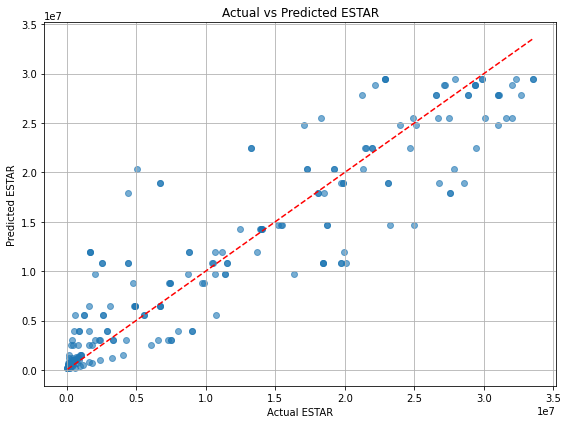

In [0]:
pred_pd = predictions.select("ESTAR", "prediction").toPandas()

plt.figure(figsize=(8,6))
plt.scatter(pred_pd["ESTAR"], pred_pd["prediction"], alpha=0.6)
plt.plot([pred_pd["ESTAR"].min(), pred_pd["ESTAR"].max()],
         [pred_pd["ESTAR"].min(), pred_pd["ESTAR"].max()], 'r--')
plt.title("Actual vs Predicted ESTAR")
plt.xlabel("Actual ESTAR")
plt.ylabel("Predicted ESTAR")
plt.grid(True)
plt.tight_layout()
plt.show()


Add More Features (with Mean Imputation)

In [0]:
extended_cols = ["FREQUENCY", "TEMPERATURE", "AIR_VOIDS_AVG_WP", "ASPHALT_CONTENT_MEAN", "ESTAR"]

for colname in extended_cols:
    df1 = df1.withColumn(colname, col(colname).cast("float"))

for colname in extended_cols:
    mean_val = df1.select(mean(colname)).first()[0]
    df1 = df1.withColumn(colname, when(col(colname).isNull(), mean_val).otherwise(col(colname)))

assembler = VectorAssembler(inputCols=extended_cols[:-1], outputCol="features")  
df_vector = assembler.transform(df1.select(*extended_cols)).select("features", "ESTAR")

train_df, test_df = df_vector.randomSplit([0.8, 0.2], seed=42)

gbt = GBTRegressor(labelCol="ESTAR", featuresCol="features", maxIter=50)
model = gbt.fit(train_df)
predictions = model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="ESTAR", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"GBT (with more features) RMSE: {rmse:.2f}")


GBT (with more features) RMSE: 1771196.28


###Residual Plot (Prediction Error)

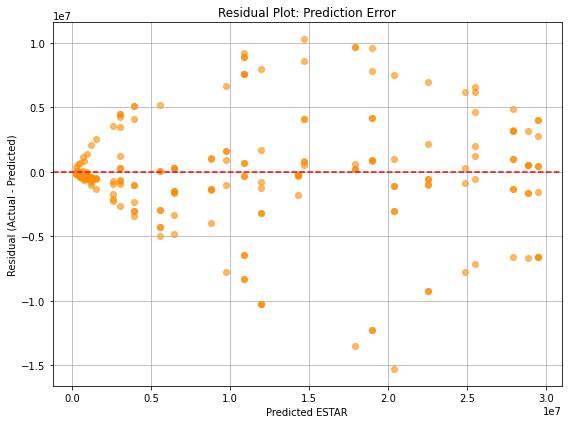

In [0]:
pred_pd["residual"] = pred_pd["ESTAR"] - pred_pd["prediction"]

plt.figure(figsize=(8,6))
plt.scatter(pred_pd["prediction"], pred_pd["residual"], alpha=0.6, color='darkorange')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot: Prediction Error")
plt.xlabel("Predicted ESTAR")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


###Histogram of Actual ESTAR Values

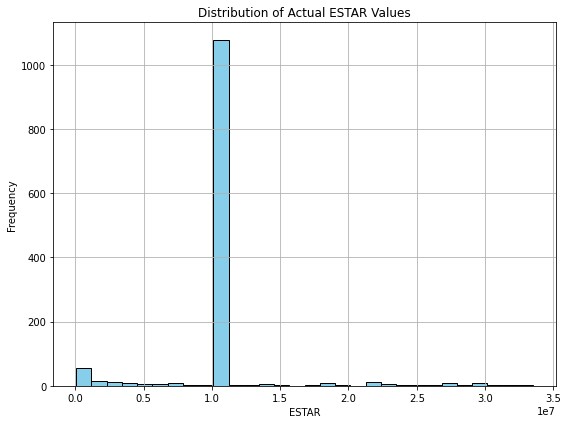

In [0]:
pred_pd = predictions.select("ESTAR", "prediction").toPandas()

plt.figure(figsize=(8,6))
plt.hist(pred_pd["ESTAR"], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Actual ESTAR Values")
plt.xlabel("ESTAR")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


###Linear Regression to Predict ESTAR

In [0]:
extended_cols = ["FREQUENCY", "TEMPERATURE", "AIR_VOIDS_AVG_WP", "ASPHALT_CONTENT_MEAN", "ESTAR"]

for colname in extended_cols:
    df1 = df1.withColumn(colname, col(colname).cast("float"))
    mean_val = df1.select(mean(colname)).first()[0]
    df1 = df1.withColumn(colname, when(col(colname).isNull(), mean_val).otherwise(col(colname)))

assembler = VectorAssembler(inputCols=extended_cols[:-1], outputCol="features")  
df_vector = assembler.transform(df1.select(*extended_cols)).select("features", "ESTAR")

train_df, test_df = df_vector.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="ESTAR")
lr_model = lr.fit(train_df)

predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="ESTAR", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"R² (coefficient of determination): {r2:.4f}")


Linear Regression RMSE: 2146002.72
R² (coefficient of determination): 0.7675


###Feature Coefficients (from model)

In [0]:
coefs = lr_model.coefficients.toArray()
intercept = lr_model.intercept
features = extended_cols[:-1]

coef_df = pd.DataFrame({"Feature": features, "Coefficient": coefs})
print("Intercept:", intercept)
print(coef_df)


Intercept: 5067597.230536106
                Feature    Coefficient
0             FREQUENCY  181865.829662
1           TEMPERATURE -726510.342407
2      AIR_VOIDS_AVG_WP      52.988428
3  ASPHALT_CONTENT_MEAN      53.498919


####Impute Missing Values for All Extended Features

In [0]:
more_features = [
    "FREQUENCY", "TEMPERATURE", "AIR_VOIDS_AVG_WP", "ASPHALT_CONTENT_MEAN",
    "THERMAL_CONDUCTIVITY", "HEAT_CAPACITY", "VOIDS_MINERAL_AGGR",
    "MAX_SPEC_GRAVITY", "BSG", "COEF_THERMAL_CONTRACTION", "ESTAR"
]

for colname in more_features:
    df1 = df1.withColumn(colname, col(colname).cast("float"))
    mean_val = df1.select(mean(colname)).first()[0]
    df1 = df1.withColumn(colname, when(col(colname).isNull(), mean_val).otherwise(col(colname)))


###Re-train Linear Regression Model

In [0]:
assembler = VectorAssembler(inputCols=more_features[:-1], outputCol="features") 
df_vector = assembler.transform(df1.select(*more_features)).select("features", "ESTAR")

train_df, test_df = df_vector.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="ESTAR")
lr_model = lr.fit(train_df)
predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="ESTAR", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"RMSE (Extended Model): {rmse:.2f}")
print(f"R² (Extended Model): {r2:.4f}")


RMSE (Extended Model): 2146002.73
R² (Extended Model): 0.7675


In [0]:
selected_cols = [
    "FREQUENCY", "TEMPERATURE", "AIR_VOIDS_AVG_WP", "ASPHALT_CONTENT_MEAN",
    "THERMAL_CONDUCTIVITY", "HEAT_CAPACITY", "VOIDS_MINERAL_AGGR",
    "MAX_SPEC_GRAVITY", "BSG", "COEF_THERMAL_CONTRACTION", "ESTAR"
]


for colname in selected_cols:
    df1 = df1.withColumn(colname, col(colname).cast("float"))
    mean_val = df1.select(mean(colname)).first()[0]
    df1 = df1.withColumn(colname, when(col(colname).isNull(), mean_val).otherwise(col(colname)))

df_pd = df1.select(*selected_cols).toPandas()


In [0]:
X = df_pd.drop(columns=["ESTAR"])
y = df_pd["ESTAR"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
ridge_r2 = r2_score(y_test, ridge_preds)

lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
lasso_r2 = r2_score(y_test, lasso_preds)

print(f"Ridge Regression RMSE: {ridge_rmse:.2f}, R²: {ridge_r2:.4f}")
print(f"Lasso Regression RMSE: {lasso_rmse:.2f}, R²: {lasso_r2:.4f}")


Ridge Regression RMSE: 2455548.39, R²: 0.7237
Lasso Regression RMSE: 2455548.68, R²: 0.7237


###Model Comparison Plot (Linear, Ridge, Lasso)

<command-1487096398225466>:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


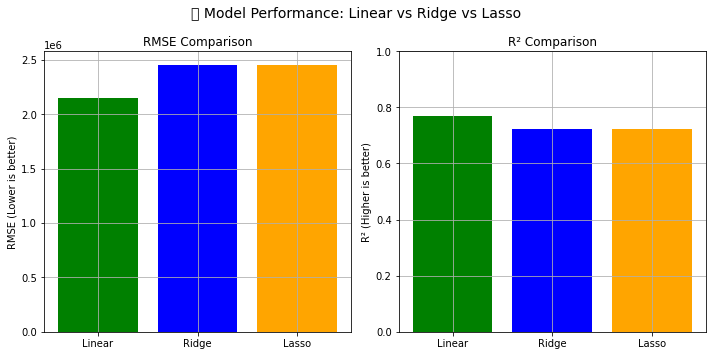

In [0]:
model_names = ["Linear", "Ridge", "Lasso"]
rmse_scores = [2146002.72, ridge_rmse, lasso_rmse]
r2_scores = [0.7675, ridge_r2, lasso_r2]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_scores, color=["green", "blue", "orange"])
plt.title("RMSE Comparison")
plt.ylabel("RMSE (Lower is better)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(model_names, r2_scores, color=["green", "blue", "orange"])
plt.title("R² Comparison")
plt.ylabel("R² (Higher is better)")
plt.ylim(0, 1)
plt.grid(True)

plt.suptitle("📊 Model Performance: Linear vs Ridge vs Lasso", fontsize=14)
plt.tight_layout()
plt.show()


In [0]:
df1 = df1.withColumn("condition",
    when(df1["ESTAR"] >= 2e7, "Good")
    .when((df1["ESTAR"] >= 1e7) & (df1["ESTAR"] < 2e7), "Fair")
    .otherwise("Poor")
)

features = ["TEMPERATURE", "FREQUENCY", "ASPHALT_CONTENT_MEAN", "AIR_VOIDS_AVG_WP"]
for colname in features:
    df1 = df1.withColumn(colname, col(colname).cast("float"))
    mean_val = df1.select(mean(colname)).first()[0]
    df1 = df1.withColumn(colname, when(col(colname).isNull(), mean_val).otherwise(col(colname)))

indexer = StringIndexer(inputCol="condition", outputCol="label")
df_indexed = indexer.fit(df1).transform(df1)

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_final = assembler.transform(df_indexed).select("features", "label")

train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

clf = RandomForestClassifier(labelCol="label", featuresCol="features")
model = clf.fit(train_df)

predictions = model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Pavement Condition Prediction Accuracy: {accuracy:.2%}")


Pavement Condition Prediction Accuracy: 98.14%


##MODEL TO PREDICT PAVEMENT CONDITION USING THE FEATURES BY USER INPUTS

In [0]:
input_data = [Row(TEMPERATURE=25.0, FREQUENCY=10.0, ASPHALT_CONTENT_MEAN=5.2, AIR_VOIDS_AVG_WP=3.1)]
input_df = spark.createDataFrame(input_data)

for colname in features:
    input_df = input_df.withColumn(colname, col(colname).cast("float"))

input_vector = assembler.transform(input_df).select("features")

prediction = model.transform(input_vector)
prediction.select("prediction").show()


+----------+
|prediction|
+----------+
|       1.0|
+----------+



In [0]:
def predict_condition(temp, freq, asphalt, voids):
    from pyspark.sql import Row
    row = [Row(TEMPERATURE=temp, FREQUENCY=freq,
               ASPHALT_CONTENT_MEAN=asphalt, AIR_VOIDS_AVG_WP=voids)]
    input_df = spark.createDataFrame(row)
    for colname in features:
        input_df = input_df.withColumn(colname, col(colname).cast("float"))
    input_vector = assembler.transform(input_df).select("features")
    result = model.transform(input_vector).select("prediction").first()[0]
    return result

pred = predict_condition(28.5, 8.0, 4.7, 2.9)
print("Predicted Condition Class:", pred)


Predicted Condition Class: 1.0


In [0]:
def interpret_prediction(pred):
    mapping = {0.0: "Good", 1.0: "Fair", 2.0: "Poor"}
    return mapping.get(pred, "Unknown")
    
print("Predicted Condition:", interpret_prediction(pred))



Predicted Condition: Fair


In [0]:
temp = float(input("Enter Temperature (°C): "))
freq = float(input("Enter Frequency (Hz): "))
asphalt = float(input("Enter Asphalt Content (%): "))
voids = float(input("Enter Air Voids (%): "))

pred = predict_condition(temp, freq, asphalt, voids)
print("Predicted Pavement Condition:", interpret_prediction(pred))


Enter Temperature (°C):  50

Enter Frequency (Hz):  300

Enter Asphalt Content (%):  61

Enter Air Voids (%):  75

Predicted Pavement Condition: Fair


###Regression-Based Life Prediction

In [0]:
df1 = df1.withColumn("AGE", (monotonically_increasing_id() % 20) + 1)  


In [0]:
life_cols = ["AGE", "TEMPERATURE", "FREQUENCY", "ASPHALT_CONTENT_MEAN", "AIR_VOIDS_AVG_WP", "ESTAR"]

for colname in life_cols:
    df1 = df1.withColumn(colname, col(colname).cast("float"))
    mean_val = df1.select(mean(colname)).first()[0]
    df1 = df1.withColumn(colname, when(col(colname).isNull(), mean_val).otherwise(col(colname)))

assembler = VectorAssembler(inputCols=life_cols[:-1], outputCol="features")  # exclude ESTAR
df_vector = assembler.transform(df1.select(*life_cols)).select("features", "ESTAR")

train_df, test_df = df_vector.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression(featuresCol="features", labelCol="ESTAR")
lr_model = lr.fit(train_df)
predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="ESTAR", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Life Prediction RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


Life Prediction RMSE: 2350120.54
R²: 0.7669


###MODEL TO PREDICT IF PAEMENT WILL FAIL IN NEXT 5 years

In [0]:
df1 = df1.withColumn("AGE", (monotonically_increasing_id() % 20) + 1) 

df1 = df1.withColumn("will_fail_5yr", when((col("ESTAR") < 1e7) & (col("AGE") <= 5), 1).otherwise(0))


In [0]:
features = ["AGE", "TEMPERATURE", "FREQUENCY", "ASPHALT_CONTENT_MEAN", "AIR_VOIDS_AVG_WP", "will_fail_5yr"]

for colname in features:
    df1 = df1.withColumn(colname, col(colname).cast("float"))
    mean_val = df1.select(mean(colname)).first()[0]
    df1 = df1.withColumn(colname, when(col(colname).isNull(), mean_val).otherwise(col(colname)))

assembler = VectorAssembler(inputCols=features[:-1], outputCol="features")
df_final = assembler.transform(df1.select(*features)).select("features", col("will_fail_5yr").alias("label"))


In [0]:
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

clf = RandomForestClassifier(featuresCol="features", labelCol="label")
model = clf.fit(train_df)

predictions = model.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"📈 ROC AUC for Pavement Failure Prediction (5-year): {roc_auc:.4f}")


📈 ROC AUC for Pavement Failure Prediction (5-year): 0.9995


####Confusion Matrix

In [0]:
predictions.groupBy("label", "prediction").count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   34|
|  0.0|       1.0|    1|
|  1.0|       0.0|    2|
|  0.0|       0.0| 1250|
+-----+----------+-----+



/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


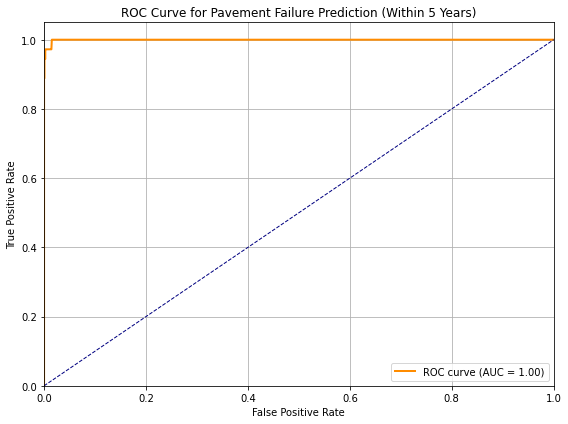

In [0]:
pred_pd = predictions.select("label", "probability").toPandas()

y_true = pred_pd["label"]
y_scores = pred_pd["probability"].apply(lambda x: float(x[1]))

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Pavement Failure Prediction (Within 5 Years)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


###Pavement Condition Classification Accuracy

In [0]:
df1 = df1.withColumn("Condition",
    when(col("ESTAR") > 1e6, "Good")
    .when((col("ESTAR") > 5e5) & (col("ESTAR") <= 1e6), "Fair")
    .otherwise("Poor")
)

feature_cols = ["FREQUENCY", "TEMPERATURE", "ASPHALT_CONTENT_MEAN", "AIR_VOIDS_AVG_WP"]
for colname in feature_cols:
    df1 = df1.withColumn(colname, col(colname).cast("float"))

for colname in feature_cols:
    mean_val = df1.select(mean(colname)).first()[0]
    df1 = df1.withColumn(colname, when(col(colname).isNull(), mean_val).otherwise(col(colname)))

indexer = StringIndexer(inputCol="Condition", outputCol="label")
df_indexed = indexer.fit(df1).transform(df1)

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_final = assembler.transform(df_indexed).select("features", "label")

train_df, test_df = df_final.randomSplit([0.7, 0.3], seed=42)

clf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=42)
model = clf.fit(train_df)

predictions = model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Pavement Condition Classification Accuracy: {accuracy:.2%}")

conf_matrix_df = predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
conf_matrix_df.show()


Pavement Condition Classification Accuracy: 97.60%
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1830|
|  0.0|       1.0|   14|
|  0.0|       2.0|    9|
|  1.0|       0.0|    7|
|  1.0|       1.0|   42|
|  1.0|       2.0|    4|
|  2.0|       0.0|    4|
|  2.0|       1.0|    8|
|  2.0|       2.0|    2|
+-----+----------+-----+



In [0]:
label_mapping = indexer.fit(df1).labels  # ['Good', 'Fair', 'Poor']

conf_matrix_df = predictions.groupBy("label", "prediction").count().toPandas()

n = len(label_mapping)
conf_matrix = np.zeros((n, n), dtype=int)

for _, row in conf_matrix_df.iterrows():
    i = int(row["label"])
    j = int(row["prediction"])
    conf_matrix[i][j] = row["count"]

conf_matrix_df = pd.DataFrame(conf_matrix, index=label_mapping, columns=label_mapping)


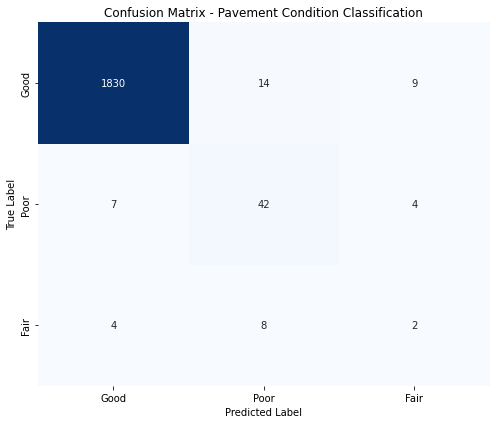

In [0]:
plt.figure(figsize=(7,6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Pavement Condition Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
